<a href="https://colab.research.google.com/github/YanivAmir/nlp-investor2startup-recommendation-system/blob/main/investors_to_startups_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from time import sleep
from random import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import re
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
def get_profiling_investments(df):
    investors, profiling_companies, investors_wo_profile = [],[],[]
    for i,investments in enumerate(df['Profiling investments']):
        if investments:
            try:
                companies = investments.split(',')
                if len(companies)>1:
                    investors.append(df['Investor'][i])
                    profiling_companies.append(companies)
                else:
                    companies = investments.split(',')
                    if len(companies) > 1:
                        investors.append(df['Investor'][i])
                        profiling_companies.append(companies)
            except:
                investors_wo_profile.append(df['Investor'][i])
    data={'Investor':investors, 'Profiling investments':profiling_companies}
    print('Investors w/o parsable profiling companies:')
    print(investors_wo_profile)
    return(pd.DataFrame.from_dict(data))

def get_company_name(homepage):
    company = homepage.split('.')[-2].split('/')[-1]
    names = [company[1:i] for i in range(4,len(company)+1)]
    names.append(company)
    return(company,names)

def scrape_text_from_search_results(query,website=False):
    if website:
        result = requests.get('https://www.google.com/search?q='+query)
    else:
        result = requests.get('https://www.google.com/search?q='+query+' company')
    html_page = result.content
    soup = BeautifulSoup(html_page, 'html.parser')
    return(soup.findAll(text=True))

In [3]:
def save_startup_df(texts,names,start_index,index):
    summary = {'Company': names,'Text': texts}
    summary = pd.DataFrame.from_dict(summary)
    #summary.to_csv('Startups Texts. Startups #'+str(start_index)+'-'+str(index+1))
    print('SAVED : Startups Texts. Startups #'+str(start_index)+'-'+str(index+1))
    return(summary)

def scrape_startups_text(startups_df, end_index, start_index=0, snippets_to_join=10, sleep_start=5, sleep_end=10,sleep_interval=150):
    print('initiating text mining for startups')
    startups_names, startups_texts = [], []
    for i in range(start_index, end_index):
        startup = startups_df['Company Name'][i]
        #html = startups_df['Website'][i]
        print(startup,end = '  ')
        sleep(randint(sleep_start, sleep_end))
        text = scrape_text_from_search_results(startup,website=False)
        non_hebrew_text = remove_hebrew(text)
        text_black_list = ['witter', 'nstagram', 'inkedin', 'html', 'oogle', '@', '=', 'px']
        text_sorted = sort_text(non_hebrew_text, text_black_list)
        startup_text = join_text(text_sorted, snippets_to_join)
        startups_names.append(startup)
        startups_texts.append(startup_text)
        if (i + 1) % 10 == 0:
            print('*******  ', i + 1, ' : scraping intermission to appease google overlords ********')
            sleep(sleep_interval)
            if (i + 1) % 30 == 0:
                save_startup_df(startups_texts, startups_names, start_index, i)
    print('\n')
    startups_texts_df = save_startup_df(startups_texts, startups_names, start_index, end_index)
    return (startups_texts_df)

def save_investors_df(investors,texts,company_names,start_index,index):
    summary = {'Investor': investors, 'Company': company_names,'Text': texts}
    summary = pd.DataFrame.from_dict(summary)
    #summary.to_csv('Investors Texts. #'+str(start_index)+'-'+str(index+1))
    print('SAVED : Investors Texts. #'+str(start_index)+'-'+str(index+1))
    return(summary)

def scrape_investors_text(investors_df,end_index, start_index=0, snippets_to_join=10, sleep_start=5, sleep_end=10,sleep_interval=150):
    print('initiating text mining for investors profiling companies')
    investors_names,companies_names,companies_texts= [],[],[]
    for j in range(start_index,end_index):
        print('\n')
        print(investors_df['Investor'][j])
        print('\t',end='')
        for i,company in enumerate(investors_df['Profiling investments'][j]):
            print(company,end = '  ')
            sleep(randint(sleep_start,sleep_end))
            text = scrape_text_from_search_results(company, website=False)
            non_hebrew_text = remove_hebrew(text)
            html_black_list = ['witter', 'nstagram', 'inkedin', 'html', 'oogle', '@', '=', 'px']
            text_sorted = sort_text(non_hebrew_text, html_black_list)
            company_text = join_text(text_sorted, snippets_to_join)
            investors_names.append(investors_df['Investor'][j])
            companies_names.append(company)
            companies_texts.append(company_text)
        if (j + 1) % 10 == 0:
            print('*******  ', j + 1, ' : intermission   ********')
            sleep(sleep_interval)
            if (j + 1) % 30 == 0:
                save_investors_df(investors_names,companies_texts, companies_names, start_index, j)
    print('\n')
    investors_texts_df = save_investors_df(investors_names, companies_texts, companies_names, start_index, end_index)
    return(investors_texts_df)



In [4]:
def word_vectorize(df,ngram_min, ngram_max,max_word_features):
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='word',
        token_pattern=r'\w{1,}', stop_words='english',ngram_range=(ngram_min, ngram_max),max_features=max_word_features)
    print('Done with word vectorizer')
    return(word_vectorizer.fit_transform(df['Text']))

def char_vectorize(df,char_min, char_max,max_char_features):
    char_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',analyzer='char',
        stop_words='english',ngram_range=(char_min, char_max),max_features=max_char_features)
    print('Done with character vectorizer')
    return(char_vectorizer.fit_transform(df['Text']))

def cosine_scoring(n_startups,n_investors,word_features,char_features,char2word_ratio):
    cosine_scores = np.zeros((n_investors,n_startups))
    for i in range(n_investors):
        cosine_word_scores = linear_kernel(word_features[i], word_features).flatten()
        cosine_char_scores = linear_kernel(char_features[i], char_features).flatten()
        cosine_scores_interim = (char2word_ratio * cosine_char_scores + cosine_word_scores) / (1 + char2word_ratio)
        cosine_scores[i] = cosine_scores_interim[n_investors:]
    return(cosine_scores)

In [5]:
def find_matches(investor_scoring,startups_text_df,num_of_matches):
    j,k = 0,0
    startups,scores = [],[]
    while j < num_of_matches:
        startup = startups_text_df.iloc[investor_scoring['company index'][k]]['Company']
        if startup not in startups:
            # startups_stats.loc[comp, 'number_of_recs'] += 1
            startups.append(startup)
            scores.append(investor_scoring['score'][j])
            j += 1
        k += 1
    return(startups,scores)

def find_max_min(investor_scoring,max_total,min_total):
    max_comp = investor_scoring['score'][0]
    if max_comp > max_total:
        max_total = max_comp
    min_comp = investor_scoring['score'].iloc[-1]
    if min_comp < min_total:
        min_total = min_comp
    return(max_total,min_total)

In [6]:
def normalize_scores(matching,max,min,num_of_matches):
    for i in range(len(matching)):
        norm_scores = [100 * (score - min) / (max - min) for score in matching['Best Scores'][i]]
        matching['Best Scores'][i] = norm_scores
    score_column_names = ['Score '+str(i + 1) for i in range(num_of_matches)]
    matching[score_column_names] = pd.DataFrame(matching['Best Scores'].tolist(), index=matching.index).round(decimals=2)
    matching = matching.drop(['Best Scores'], axis=1)
    #pd.set_option('precision', 2)
    return(matching)

In [7]:
def sort_text(text,black_list):
    text_dict = {}
    text_dict['word #'],text_dict['text'],positive_index,positive_text= [],[],[],[]
    for i, snipett in enumerate(text):
        if not any(word in snipett for word in black_list):
            positive_index.append(i)
            positive_text.append(snipett)
            text_dict['text'].append(snipett)
            text_dict['word #'].append(len(snipett))
    text_sorted = pd.DataFrame.from_dict(text_dict).sort_values(by='word #', axis=0, ascending=False)
    return(text_sorted)

def remove_hebrew(text_list):
    non_hebrew_text = []
    for snippet in text_list:
        non_hebrew = re.sub(r'[^A-Za-z ]+', '', snippet)
        if non_hebrew[:11] != 'functionvar':
            non_hebrew_text.append(non_hebrew)
    return(non_hebrew_text)

def join_text(text_sorted,snippets_to_join):
    return('\n '.join(text_sorted['text'][:snippets_to_join]))

def edit_combined_text(df,words_black_list):
  company,final_text,text_length = [],[],[]
  for i in range(len(df)):
      # labels.append(companies_df['Industry Categories'][i]) #[companies_df['Company Name']==df['Company']
      joined_text =  df['Text'][i] #+ companies_df['Description and Metrics'][i]
      joined_text = re.sub(r'[^A-Za-z ]+', '', joined_text).lower().split(' ')
      joined_text =  ' '.join([word for word in joined_text if word not in words_black_list])
      joined_text = joined_text.replace('  ',' ')
      final_text.append(joined_text)
      company.append(df['Company'][i])
      text_length.append(len(joined_text))
  data_text = {'Company':company, 'Text Length': text_length, 'Text': final_text}  #, 'Labels': labels}
  data_text = pd.DataFrame.from_dict(data_text)
  print('Texts Length Statistics:')
  print(data_text['Text Length'].describe())
  return(df,data_text)


In [8]:
def find_startups(startups_text_df,cosine_scores,investors_df,num_of_matches=5,individually=True,
                  investors='all',max_stndrd=0,min_stndrd=0):
    all_investors_names, all_investors_profiling_companies,all_investors_matches,all_investors_matches_scores = [],[],[],[]
    max_total, min_total = 0, 1
    if investors=='all':
        investors = list(set(investors_df.Investor.dropna()))
        investors.sort()
    for investor in investors:
        all_investors_names.append(investor)
        print(investor,end=' ')
        investor_indices = investors_df.index[investors_df['Investor'] == investor].tolist()
        all_investors_profiling_companies.append(investors_df.loc[investor_indices, 'Company'].tolist())
        for index in investor_indices:
            # print('\t', investor_df.loc[index, 'Company'])
            cosine_similarities_sorted = np.sort(cosine_scores[index])[::-1]
            similar_comp_indices_sorted = cosine_scores[index].argsort()[::-1]
            interim = pd.DataFrame([similar_comp_indices_sorted, cosine_similarities_sorted]).T
            interim.columns = ['company index', 'score']
            if index == investor_indices[0]:
                investor_scoring = interim
            if index != investor_indices[0] and individually:
                investor_scoring = pd.concat([investor_scoring, interim])
            if index != investor_indices[0] and not individually:
                investor_scoring = investor_scoring.merge(interim, how='left', on='company index')
        if not individually:
            investor_scoring['score'] = investor_scoring.iloc[:, 1:].mean(axis=1)
        investor_scoring = investor_scoring.sort_values(by='score', ascending=False).reset_index()
        investor_scoring = investor_scoring.astype({"company index": int})
        max_total, min_total = find_max_min(investor_scoring,max_total,min_total)
        investor_matches, matches_scores = find_matches(investor_scoring,startups_text_df,num_of_matches)
        all_investors_matches.append(investor_matches)
        all_investors_matches_scores.append(matches_scores)
    print('max cosine score: ', round(max_total,2))
    print('min cosine score:', round(min_total,2))
    matching_df = pd.DataFrame.from_dict({'Investor':all_investors_names,'Profiling Companies':all_investors_profiling_companies,
                                  'Best Matches': all_investors_matches, 'Best Scores':all_investors_matches_scores})
    if max_stndrd==0 and min_stndrd==0:
        matching_df = normalize_scores(matching_df,max_total,min_total,num_of_matches)
    else:
        matching_df = normalize_scores(matching_df, max_stndrd,min_stndrd, num_of_matches)
    return(matching_df)


In [9]:
def create_score_matrix_df(matching_df,startups_text_df):
    all_startups = startups_text_df['Company'].tolist()
    all_startups.sort()
    investors2startups = pd.DataFrame(np.zeros((len(matching_df),len(all_startups))), columns=all_startups, index = matching_df['Investor'])
    for i,investor in enumerate(matching_df['Investor']):
        print(investor,end=' ')
        investor_scores = pd.DataFrame([matching_df.loc[i,'Best Matches'],matching_df.iloc[i, 3:].values]).T
        investor_scores.columns=['startups','scores']
        # investor_scores = investor_scores.sort_values(by='startups')
        investor_startups = investor_scores.startups.values
        for j,startup in enumerate(investor_startups):
            investors2startups[startup][i] = investor_scores.loc[investor_scores['startups']==startup,'scores'].values
    print('\n')
    return(investors2startups)

In [10]:
def calc_distances(score_mat_df):
    startup_distances = np.zeros((score_mat_df.shape[1],score_mat_df.shape[1]))
    for i in range(score_mat_df.shape[1]):
        for j in range(i):
            startup_distances[i,j]=np.linalg.norm(score_mat_df.iloc[:,i].values - score_mat_df.iloc[:,j].values)
    investor_distances = np.zeros((score_mat_df.shape[0],score_mat_df.shape[0]))
    for i in range(score_mat_df.shape[0]):
        for j in range(i):
            startup_distances[i,j]=np.linalg.norm(score_mat_df.iloc[i,:].values - score_mat_df.iloc[j,:].values)
    return(startup_distances,investor_distances)

In [11]:
# Extract only top 3 scores and Best Matches
def get_top_n(df, n=3):
    top_n_df = df[['Profiling Companies']].copy()
    top_n_df['Best Matches'] = df['Best Matches'].apply(lambda x: x[:n])
    for i in range(1, n + 1):
        top_n_df[f'Score {i}'] = df[f'Score {i}']
    return top_n_df

# Reverse table: Companies as index, Investors as Best Matches
def reverse_table(df, n=3):
    reverse_df = pd.DataFrame(columns=['Best Matches', 'Score 1', 'Score 2', 'Score 3'])
    for company in df['Best Matches'].explode().unique():
        top_investors = []
        top_scores = []
        for investor, row in df.iterrows():
            if company in row['Best Matches']:
                score_idx = row['Best Matches'].index(company)
                top_investors.append((investor, row[f'Score {score_idx + 1}']))
        top_investors = sorted(top_investors, key=lambda x: x[1], reverse=True)[:n]
        reverse_df.loc[company] = [
            [inv[0] for inv in top_investors],
            *[inv[1] for inv in top_investors]
        ]
    return reverse_df

initiating text mining for startups
Johnson&Johnson  Coca-Cola Company  Gucci  Mattel  Intel  H&M  Crowdstrike  Tesla  Shopify  

SAVED : Startups Texts. Startups #0-10
Investors w/o parsable profiling companies:
[]
initiating text mining for investors profiling companies


Trixie
	BioNTech  Pfizer  Bayer  

BenDela
	Mcdonalds  Pepsi  Nestle  

Mone
	Dior  Prada  

Juju
	Toys"R"Us  Lego  

Alaska
	Nvidia  AMD  

Plastique
	Palo Alto Networks  Checkpoint  

Jinkx
	Toyota  Ford  

Katya
	Alibaba Group  Amazon  

SAVED : Investors Texts. #0-9
Texts Length Statistics:
count      27.000000
mean     1201.259259
std       170.483383
min       891.000000
25%      1119.000000
50%      1183.000000
75%      1249.500000
max      1775.000000
Name: Text Length, dtype: float64
mining text is complete
Done with word vectorizer
Done with character vectorizer
(18, 9)
cosine matrix was saved
Alaska BenDela Jinkx Juju Katya Mone Plastique Trixie max cosine score:  0.2
min cosine score: 0.04

Investor-Focu

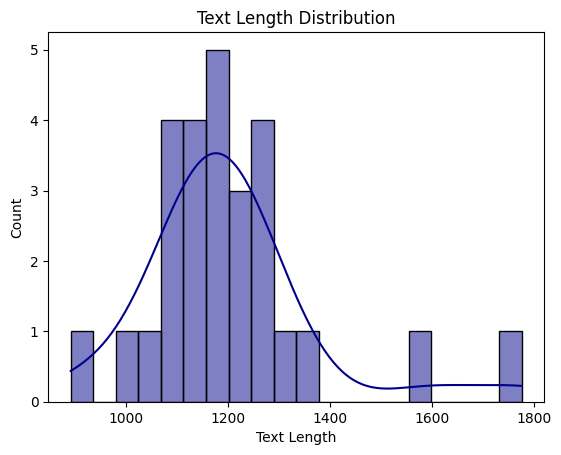

In [14]:
if __name__=="__main__":

    savePath= '/path/to/save/folder/'
    snippets_to_join = 10
    start_index=0
    sleep_start=5
    sleep_end=10
    sleep_interval=150
    recommendations_per_investor = 10
    words_black_list = ['rasing','company','series','revenue','usd','seed','round','followers','linkedin','twitter','contact','employees','it','location','view','is','in','a','an','that','this','these','and','if','or','to','by','are','the','of','with','for','etc','at','via']
    ngram_min = 1
    ngram_max = 4
    max_word_features = 20000
    char_min = 3
    char_max = 7
    max_char_features = 50000
    char_vs_word_score_ratio = 3

    # Example Data
    startup_names = ['Johnson&Johnson','Coca-Cola Company','Gucci','Mattel','Intel','H&M','Crowdstrike','Tesla','Shopify']
    startup_websites = []
    startups_df = pd.DataFrame([startup_names,startup_websites]).T
    startups_df.columns=['Company Name','Website']

    investors = ['Trixie','BenDela','Mone','Juju','Alaska','Vivienne','Plastique','Jinkx','Katya']
    investors_profiling_investments = ['BioNTech,Pfizer,Bayer','Mcdonalds,Pepsi,Nestle','Dior,Prada','Toys"R"Us,Lego','Nvidia,AMD','Zara','Palo Alto Networks,Checkpoint','Toyota,Ford','Alibaba Group,Amazon']
    investors_df = pd.DataFrame([investors,investors_profiling_investments]).T
    investors_df.columns=['Investor','Profiling investments']

    # Text mining
    #startups_df = pd.read_csv('path/to/strartups.csv')
    end_index=len(startups_df)
    startups_texts_df = scrape_startups_text(startups_df,end_index,start_index,snippets_to_join,sleep_start,sleep_end,sleep_interval)
    startups_texts_df = startups_texts_df.drop_duplicates(subset='Company').reset_index()
    #investors_df = pd.read_csv("/'path/to/investors.csv'.csv")
    investors_df = get_profiling_investments(investors_df)
    end_index=len(investors_df)
    investors_text_df = scrape_investors_text(investors_df,end_index,start_index,snippets_to_join,sleep_start,sleep_end,sleep_interval)
    investors_text_df = investors_text_df.dropna().reset_index()
    combined_df = pd.concat([investors_text_df,startups_texts_df]).reset_index()
    combined_df,data_text = edit_combined_text(combined_df,words_black_list)
    ax = sns.histplot(data_text['Text Length'], kde=True,bins = 20, color = 'darkblue')
    ax.set_title('Text Length Distribution')
    ax.set_xlabel('Text Length')
    n_startups = len(startups_texts_df)
    n_investors = len(investors_text_df)
    print('mining text is complete')

    # Text vectorisation and cosine similarities
    word_features = word_vectorize(combined_df,ngram_min,ngram_max,max_word_features)
    char_features = char_vectorize(combined_df,char_min,char_max,max_char_features)
    cosine_matrix = cosine_scoring(n_startups,n_investors,word_features,char_features,char_vs_word_score_ratio)
    print(cosine_matrix.shape)
    np.save('cosine_matrix', cosine_matrix)
    print('cosine matrix was saved')

    # Finding matches based on cosine similarities' matrix
    matching_investors_to_startups = find_startups(startups_texts_df,cosine_matrix,investors_text_df,len(startups_texts_df),individually=False,investors='all')
    matching_investors_to_startups.set_index('Investor',inplace=True)
    matching_investors_to_startups.to_csv('matching_investors_to_startups')
    # Generate the smaller investor-focused table
    smaller_investor_table = get_top_n(matching_investors_to_startups)
    print("\nInvestor-Focused Table:")
    print(smaller_investor_table)
    # Generate the reverse table with companies as index
    reverse_table_df = reverse_table(matching_investors_to_startups)
    print("\nReversed Table with Companies as Index:")
    print(reverse_table_df)

    print('Results where profiling companies are matched individually and the max score is taken for eahc investor:')
    matching_investors_to_startups = find_startups(startups_texts_df,cosine_matrix,investors_text_df,len(startups_texts_df),individually=True,investors='all')
    matching_investors_to_startups.set_index('Investor',inplace=True)
    # Generate the smaller investor-focused table
    smaller_investor_table = get_top_n(matching_investors_to_startups)
    print("\nSmaller Investor-Focused Table:")
    print(smaller_investor_table)
    # Generate the reverse table with companies as index
    reverse_table_df = reverse_table(matching_investors_to_startups)
    print("\nReversed Table with Companies as Index:")
    print(reverse_table_df)
